In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def ReadPGM(name):
    with open(name) as f:
        lines = f.readlines()
        
    # Ignores commented lines
    for l in list(lines):
        if l[0] == '#':
            lines.remove(l)
    
    # Makes sure it is ASCII format (P2)
    assert lines[0].strip() == 'P2'

    # Converts data to a list of integers
    data = []
    for line in lines[1:]:
        data.extend([int(c) for c in line.split()])

    return (np.array(data[3:]),(data[1],data[0]),data[2])

In [3]:
def ShowPGM(img_path):
    image = ReadPGM(img_path)
    # plot the initial image
    plt.imshow(np.reshape(image[0], image[1]), cmap="gray")
    plt.title("Image %s"%img_path)
    plt.show()

def Draw_hist(img_path):
    image = ReadPGM(img_path)
    # plot the histogram of image 
    pixels = image[0]
    plt.hist(pixels, bins=image[2])
    plt.title("Histogram of pixels of %s"%img_path)
    plt.show()

In [4]:
def thresholding_clear(img_path, thresholding):
    image = ReadPGM(img_path)
    pixels = image[0]
    pixels[pixels<thresholding]= 0
    pixels[pixels>=thresholding]= 255

    plt.imshow(np.reshape(pixels, image[1]), cmap="gray")
    plt.title("The Binary Image")
    plt.show()
    return np.reshape(pixels, image[1])

def binary_pixels(pixels_matrix):
    pixels_matrix[pixels_matrix==0] = 1
    pixels_matrix[pixels_matrix==255] = 0
    return pixels_matrix
    

In [5]:
def _label_cluster(binary):
    binary_matrix = binary.copy()
    binary_matrix[binary_matrix==1] = -1
    parent = {}
    parent_index = 1
    for index, line in enumerate(binary_matrix): 
        for col, current in enumerate(line): 
            if current != 0:
                if current == -1:
                    parent[parent_index] = 0
                    binary_matrix[index][col] = parent_index
                                        
                if index != len(binary_matrix) - 1:
                    if binary_matrix[index+1][col] == -1:
                        binary_matrix[index+1][col] = binary_matrix[index][col]
                    elif binary_matrix[index+1][col] > 0 and binary_matrix[index+1][col]!= binary_matrix[index][col]:
                        root1 = get_root(parent, binary_matrix[index+1][col])
                        root2 = get_root(parent, binary_matrix[index][col])
                        if root1!=root2:
                            parent[max(root1, root2)] = min(root1, root2)
                        
                        # parent[max(binary_matrix[index+1][col],binary_matrix[index][col])] = min(binary_matrix[index+1][col],binary_matrix[index][col])
                        
                        
                if col == len(line) - 1:
                    break
                    
                if index != len(binary_matrix) - 1:
                    if binary_matrix[index+1][col+1] == -1:
                        binary_matrix[index+1][col+1] = binary_matrix[index][col]
                    elif binary_matrix[index+1][col+1] > 0 and binary_matrix[index+1][col+1]!= binary_matrix[index][col]:
                        root1 = get_root(parent,binary_matrix[index+1][col+1])
                        root2 = get_root(parent,binary_matrix[index][col])
                        if root1!=root2:
                            parent[max(root1, root2)] = min(root1, root2)
                        
                if binary_matrix[index][col+1] == -1:
                    binary_matrix[index][col+1] = binary_matrix[index][col]
                elif binary_matrix[index][col+1] == 0 and parent_index in parent.keys():
                    parent_index += 1
                elif binary_matrix[index][col+1] > 0 and binary_matrix[index][col+1]!= binary_matrix[index][col]:
                    root1 = get_root(parent, binary_matrix[index][col+1])
                    root2 = get_root(parent, binary_matrix[index][col])
                    if root1 != root2:
                        parent[max(root1, root2)] = min(root1, root2)
                
    return binary_matrix, parent
   
def get_root(_parent, value):
    temp = _parent[value]
    if temp == 0:
        return value
    
    while _parent[temp] != 0:
        temp = _parent[temp]
    
    return temp

def sort_parent(_parent):
    for key, values in _parent.items():
        temp = _parent[key]
        if temp == 0:
            continue
        while _parent[temp] != 0:
            temp = _parent[temp]

        _parent[key] = temp
    
def _label_parent_transfer(bin_matrix, parent):
    matrix = bin_matrix.copy()
    sort_parent(parent)
    for row, line in enumerate(matrix):
        for col, current in enumerate(line):
            if current in parent.keys() and parent[current] != 0:
                matrix[row][col] = parent[current]
    return matrix

def clear_small_cluster(matrix, _parent, _filter):
    dellist = []
    for key, value in _parent.items():
        if value == 0:
            count = np.sum(matrix==key)
            if count <= _filter:
                matrix[matrix==key] = 0
                dellist.append(key)
                for key2, value2 in _parent.items():
                    if value2 == key:
                        dellist.append(key2)
    
    for i in dellist:
        _parent.pop(i)    
    

In [6]:
def dilation(img_matrix, S=None, _origin=None):
    if S is None:
        structure = np.array([[1,1,1],[1,1,1],[1,1,1]])
        origin = [1, 1]
    else:
        structure = S
    
    if _origin == None:
        origin = [len(structure)//2, len(structure[0])//2]
    else:
        origin = _origin
    
    rows, cols = img_matrix.shape
    S_rows, S_cols = structure.shape
    
    handle_matrix = img_matrix.copy()
    
    for row in range(origin[0], rows - (S_rows-origin[0]) + 1):
        for col in range(origin[1], cols - (S_cols-origin[1]) + 1):
            if img_matrix[row][col] == 1:
                handle_matrix[row-origin[0]:row-origin[0]+S_rows,col-origin[1]:col-origin[1]+S_cols] |= structure
        
    return handle_matrix
    
def erosion(img_matrix, S=None, _origin=None):
    if S is None:
        structure = np.array([[1,1,1],[1,1,1],[1,1,1]])
        origin = [1, 1]
    else:
        structure = S
    
    if _origin == None:
        origin = [len(structure)//2, len(structure[0])//2]
    else:
        origin = _origin
        
    rows, cols = img_matrix.shape
    S_rows, S_cols = structure.shape
    
    handle_matrix = np.full(img_matrix.shape, 0)
    
    for row in range(origin[0], rows - (S_rows-origin[0]) + 1):
        for col in range(origin[1], cols - (S_cols-origin[1]) + 1):
            partition = img_matrix[row-origin[0]:row-origin[0]+S_rows,col-origin[1]:col-origin[1]+S_cols] & structure
            if np.all(partition==1):
                handle_matrix[row][col] = 1
                
        
    return handle_matrix

def closing(matrix, S=None, origin=None, n=1):
    temp_matrix = matrix.copy()
    for i in range(n):
        temp_matrix = dilation(temp_matrix, S, origin, n)
        
    for i in range(n):
        temp_matrix = erosion(temp_matrix, S, origin, n)
        
    return temp_matrix

def opening(matrix, S=None, origin=None, n=1):
    temp_matrix = matrix.copy()
    for i in range(n):
        temp_matrix = erosion(temp_matrix, S, origin)
        
    for i in range(n):
        temp_matrix = dilation(temp_matrix, S, origin)
        
    return temp_matrix
   

In [7]:
def conneted_components_label(bin_matrix):
    result, parent = _label_cluster(bin_matrix)
    matrix = _label_parent_transfer(result, parent)
    clear_small_cluster(matrix, parent, 20)
    
    cluster_mark = []
    for key in parent.keys():
        if parent[key] == 0:
            cluster_mark.append(key)
            
    clu_id = []
    for i in range(len(cluster_mark)):
        clu_id.append(i+1)
        if cluster_mark[i] != i+1:
            matrix[matrix==cluster_mark[i]]=i+1
 
    return matrix, clu_id

In [8]:
def separator(_matrix, clu_id, offset=5, clear_distraction=True):
    shapex, shapey = _matrix.shape
    # assert clu_id in cluster_id
    
    rows, cols = np.where(_matrix==clu_id)
    if len(rows)==0 or len(cols) == 0:
        return
    left = min(rows)-offset 
    right = max(rows)+offset
    top = min(cols)-offset
    bottom = max(cols)+offset
    
    if left < 0:
        left = 0
    if right > shapex:
        right=shapex
    if top < 0:
        top = 0
    if bottom > shapey:
        bottom = shapey
    
    partion_matrix = _matrix[left:right, top:bottom].copy()
    
    if clear_distraction == True:
        partion_matrix[partion_matrix!=clu_id] = 0
    partion_matrix[partion_matrix==clu_id] = 1
    
    return partion_matrix


In [40]:
class Pattern:
    def __init__(self, _name, _matrix, n_close=0, _S=None, _origin=None):
        self.name = _name
        self.matrix = _matrix.copy()
        self.shape = self.matrix.shape
        self.left, self.top, self.right, self.bottom = self.Bounding_Box()
        #self.fill_holes(n_close,_S, _origin)
        self.fill_holes()
        self.area = self.Area()
        self.centroid = self.Centroid()
        self.perimeter = self.Perimeter()
        self.circularity1 = self.Circularity1()
        self.second_moment = self.Second_moment()
        
        
    def Area(self):
        return self.matrix.sum()
        
    def Centroid(self):
        centerRowSum = 0
        centerColSum = 0
        for row, lines in enumerate(self.matrix):
            for col, value in enumerate(lines):
                if value == 1:
                    centerRowSum += row
                    centerColSum += col
        return (centerRowSum/self.area, centerColSum/self.area)
    
    def Perimeter(self):
        perimeter = 0
        for row, lines in enumerate(self.matrix):
            for col, value in enumerate(lines):
                if value == 1:
                    neiber4 = 0
                    
                    if row-1 >= 0 and self.matrix[row-1][col] == 1:
                        neiber4 += 1
                    if col-1 >= 0 and self.matrix[row][col-1] == 1:
                        neiber4 += 1
                    if col+1 < self.shape[1] and self.matrix[row][col+1] == 1:
                        neiber4 += 1
                    if row + 1 < self.shape[0] and self.matrix[row+1][col] == 1:
                        neiber4 +=1
                    if neiber4 == 1:
                        perimeter += 1
                    
                    
                    
                    if row-1 >= 0 and col-1 >= 0 and self.matrix[row-1][col-1] != 1:
                        perimeter += 1
                        continue
                    
                    if row-1 >= 0 and self.matrix[row-1][col] != 1:
                        perimeter += 1
                        continue
                        
                    if row-1 >= 0 and col+1 < self.shape[1] and self.matrix[row-1][col+1] != 1:
                        perimeter += 1
                        continue
                        
                    if col-1 >= 0 and self.matrix[row][col-1] != 1:
                        perimeter += 1
                        continue
                    
                    if col+1 < self.shape[1] and self.matrix[row][col+1] != 1:
                        perimeter += 1
                        continue
                    
                    if row + 1 < self.shape[0] and col-1 >= 0 and self.matrix[row+1][col-1] != 1:
                        perimeter += 1
                        continue
                        
                    if row + 1 < self.shape[0] and self.matrix[row+1][col] != 1:
                        perimeter += 1
                        continue
                        
                    if row + 1 < self.shape[0] and col+1 < self.shape[1] and self.matrix[row+1][col+1] != 1:
                        perimeter += 1
                        continue
                        
        return perimeter
    
    
    def fill_holes(self):
        temp_matrix = np.full(self.shape, 1)
        temp_matrix ^= self.matrix
        
        result, parent = _label_cluster(temp_matrix)
        matrix = _label_parent_transfer(result, parent)

        cluster_mark = []
        for key in parent.keys():
            if parent[key] == 0:
                cluster_mark.append(key)
        
        if len(cluster_mark) > 1:
            r, c = np.where(matrix!=1)
            
            for index, rr in enumerate(r):
                self.matrix[rr][c[index]] = 1
        
    
    def get_centroid(self):
        return self.centroid
    
    def get_area(self):
        return self.area
    
    def Circularity1(self):
        return self.perimeter * self.perimeter / self.area
    
    def Bounding_Box(self):
        left, right, top, bottom = -1,-1,-1,-1
        for i, line in enumerate(self.matrix):
            if line.sum() > 0:
                top = i
                break
                
        for i in range(self.shape[0]-1,-1, -1):
            if self.matrix[i].sum() > 0:
                bottom = i
                break
        
        for i in range(0, self.shape[1]):
            if self.matrix[:, i].sum() > 0:
                left = i
                break
                
        for i in range(self.shape[1]-1, -1, -1):
            if self.matrix[:, i].sum() > 0:
                right = i
                break
                
        return left, top, right, bottom
    
    def info(self):
        print("name: %s"%self.name)
        print("centroid: %.2f, %.2f"%(self.centroid[0], self.centroid[1]))
        print("perimeter: %s"%self.perimeter)
        print("area: %s"%self.area)
        print("circularity1: %.2f"%self.circularity1)
        print("urr: %.2f, urc: %.2f, ucc: %.2f"%(self.second_moment))
        print("bounding box:")
        print("left: %s top :%s right: %s bottom: %s"%(self.left, self.top, self.right, self.bottom))
    
    def Second_moment(self):
        centroid_r, centroid_c = self.centroid
        urr, urc, ucc = 0, 0, 0
        for row in range(self.top, self.bottom+1):
            for col in range(self.left, self.right+1) :
                if self.matrix[row][col] == 1:
                    urr += (row-centroid_r)**2
                    urc += (row-centroid_r)*(col-centroid_c)
                    ucc += (col-centroid_c)**2
                    
        return urr/self.area, urc/self.area, ucc/self.area
        
    def display(self, _cmap="coolwarm"):
        plt.imshow(self.matrix, cmap=_cmap)
        plt.title("Image %s"%self.name)
        plt.show()


In [41]:
class ImagePatterns:
    def __init__(self, _matrix, clu_id):
        self.cluster_id = clu_id.copy()
        self.matrix = _matrix
        self.clusters = self.generate_clusters()
        
    def generate_clusters(self):
        classes = {}
        for i in self.cluster_id:
            pat = separator(self.matrix, i)
            pat_class = Pattern("cluster%s"%i, pat)
            classes[i] = pat_class
        return classes
    
    def delete_cluster(self, *clu_id):
        for i in clu_id:
            if i in self.clusters.keys():
                del self.clusters[i]
                self.cluster_id.remove(i)
                
    def showDetail(self, *clu_id):
        for i in clu_id:
            if i in self.clusters.keys():
                print("Cluster %s"%i)
                self.clusters[i].info()
    
    def display(self, *clu_id):
        for i in clu_id:
            if i in self.clusters.keys():
                self.clusters[i].display()
            else:
                print("Cluster %s is not exist"%i)
                
    def display_detail(self, *clu_id):
        self.showDetail(*clu_id)
        self.display(*clu_id)
    
    def display_all(self):
        for i in self.cluster_id:
            self.display_detail(i)
    
    def get_cluster_id(self):
        return self.cluster_id
    
    

In [42]:
def Objects_Extraction(img_path):
    ShowPGM(img_path)
    Draw_hist(img_path)
    default_structure = [np.full((1,3),1), np.full((11,11),1), np.full((1,1),1), np.full((2,3),1), np.full((2,2),1)]
    default_thresholding = [200, 180, 200, 150, 200]
    default_img = False
    if img_path[-10:] == "image1.pgm":
        yes = input("The default structure for opening is %s and thresholding is %s, would you like to use them(Y/N):"%(default_structure[0].shape, default_thresholding[0]))
        structure = default_structure[0]
        thresholding = default_thresholding[0]
        default_img = True
    elif img_path[-10:] == "image2.pgm":
        yes = input("The default structure for opening is %s and thresholding is %s, would you like to use them(Y/N):"%(default_structure[1].shape, default_thresholding[1]))
        structure = default_structure[1]
        thresholding = default_thresholding[1]
        default_img = True
    elif img_path[-10:] == "image3.pgm":
        yes = input("The default structure for opening is %s and thresholding is %s, would you like to use them(Y/N):"%(default_structure[2].shape, default_thresholding[2]))
        structure = default_structure[2]
        thresholding = default_thresholding[2]
        default_img = True
    elif img_path[-10:] == "image4.pgm":
        yes = input("The default structure for opening is %s and thresholding is %s, would you like to use them(Y/N):"%(default_structure[3].shape, default_thresholding[3]))
        structure = default_structure[3]
        thresholding = default_thresholding[3]
        default_img = True
    elif img_path[-10:] == "image5.pgm":
        yes = input("The default structure for opening is %s and thresholding is %s, would you like to use them(Y/N):"%(default_structure[4].shape, default_thresholding[4]))
        structure = default_structure[4]
        thresholding = default_thresholding[4]
        default_img = True
    
    
    if not default_img or yes != 'Y' and yes != 'y':
        color_width = ReadPGM(img_path)[2]
        thresholding = input("Please input the thresholding (from 0 to %s) based on the histogram: "%color_width)
        while not thresholding.isdecimal() :
            thresholding = input("Please input the number between 0 and %s: "%color_width)
        while int(thresholding) < 0 or int(thresholding) > color_width:
            thresholding = input("Please input the number between 0 and %s: "%color_width)
        thresholding = int(thresholding)
        
    pixels = thresholding_clear(img_path,thresholding)
    pixels = binary_pixels(pixels)
    
    
    if not default_img or yes != 'Y' and yes != 'y':
        structure_r = input("Please input the row of the structure matrix for opening you define: ")
        while not structure_r.isdecimal() or int(structure_r) <= 0:
            structure_r = input("Please input the a digit greater than 0 for row of the structure: ")
        
        structure_c = input("Please input the column of the structure matrix for opening you define: ")
        while not structure_c.isdecimal() or int(structure_c) <= 0:
            structure_c = input("Please input the a digit greater than 0 for column of the structure: ")
            
        structure_r = int(structure_r)
        structure_c = int(structure_c)
        structure = np.full((structure_r, structure_c),1)
        
    pixels_clear = opening(pixels,S=structure, n=1)
    plt.imshow(pixels_clear^np.full(pixels_clear.shape, 1), cmap="gray")
    plt.title("Noise Removed Image")
    plt.show()    
    
    
    # label object by connected component
    pixels_labeled, cluster_id = conneted_components_label(pixels_clear)
    print("There are %s objects being extracted"%len(cluster_id))
    plt.imshow(pixels_labeled, cmap="coolwarm")
    plt.title("Labeled Image")
    plt.show()
    
    # objects display
    image = ImagePatterns(pixels_labeled, cluster_id)
    image.display_all()
    return image
    

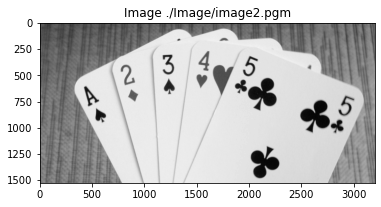

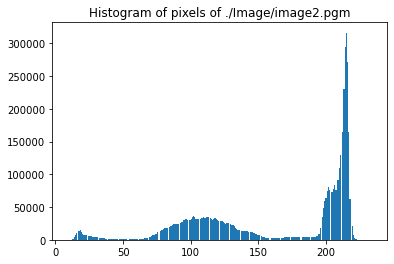

The default structure for opening is (11, 11) and thresholding is 180, would you like to use them(Y/N):y


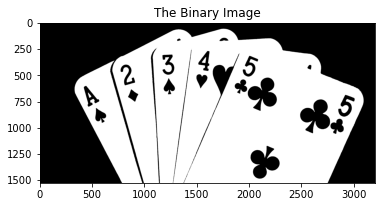

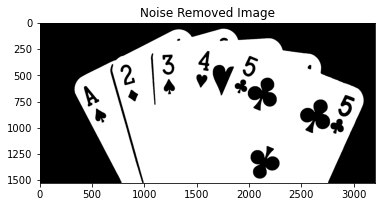

There are 22 objects being extracted


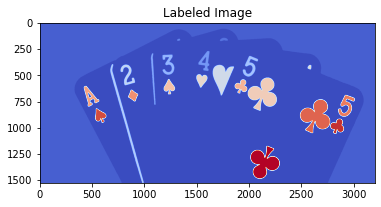

Cluster 1
name: cluster1
centroid: 608.86, 1403.05
perimeter: 6684
area: 1749951
circularity1: 25.53
urr: 252365.03, urc: -79612.78, ucc: 1508351.70
bounding box:
left: 0 top :0 right: 3200 bottom: 1526


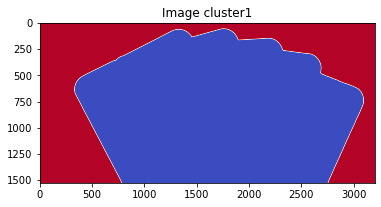

Cluster 2
name: cluster2
centroid: 20.52, 42.16
perimeter: 216
area: 1689
circularity1: 27.62
urr: 56.58, urc: -25.65, ucc: 400.63
bounding box:
left: 5 top :5 right: 80 bottom: 35


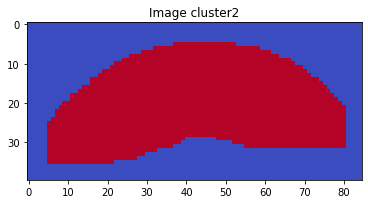

Cluster 3
name: cluster3
centroid: 14.75, 18.63
perimeter: 92
area: 465
circularity1: 18.20
urr: 26.49, urc: -11.42, ucc: 58.28
bounding box:
left: 5 top :5 right: 32 bottom: 24


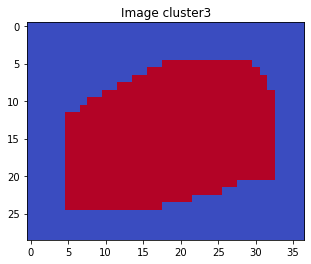

Cluster 4
name: cluster4
centroid: 101.05, 68.59
perimeter: 662
area: 10477
circularity1: 41.83
urr: 2079.14, urc: -211.35, ucc: 580.60
bounding box:
left: 5 top :5 right: 109 bottom: 193


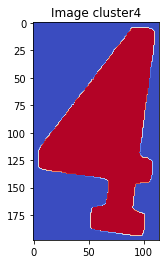

Cluster 5
name: cluster5
centroid: 233.91, 26.12
perimeter: 1074
area: 7205
circularity1: 160.09
urr: 18875.29, urc: 1181.76, ucc: 95.16
bounding box:
left: 5 top :5 right: 48 bottom: 493


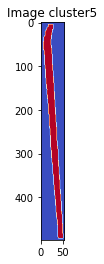

Cluster 6
name: cluster6
centroid: 94.39, 62.61
perimeter: 1018
area: 9909
circularity1: 104.58
urr: 3693.35, urc: 282.07, ucc: 857.84
bounding box:
left: 5 top :5 right: 116 bottom: 195


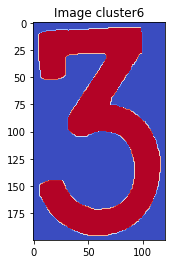

Cluster 7
name: cluster7
centroid: 103.38, 75.61
perimeter: 1082
area: 10639
circularity1: 110.04
urr: 3261.64, urc: -603.81, ucc: 1113.59
bounding box:
left: 5 top :5 right: 148 bottom: 200


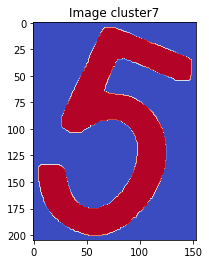

Cluster 8
name: cluster8
centroid: 560.60, 153.16
perimeter: 2905
area: 22837
circularity1: 369.53
urr: 101364.99, urc: 28435.62, ucc: 8022.94
bounding box:
left: 5 top :5 right: 322 bottom: 1138


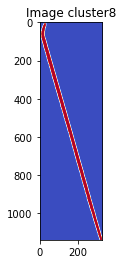

Cluster 9
name: cluster9
centroid: 103.47, 72.23
perimeter: 1028
area: 9420
circularity1: 112.19
urr: 3717.57, urc: 683.25, ucc: 1045.42
bounding box:
left: 5 top :5 right: 141 bottom: 200


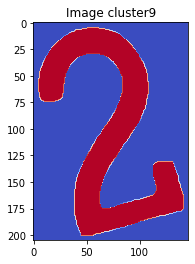

Cluster 10
name: cluster10
centroid: 117.61, 91.76
perimeter: 1076
area: 31481
circularity1: 36.78
urr: 4383.62, urc: -174.51, ucc: 1988.88
bounding box:
left: 5 top :5 right: 205 bottom: 294


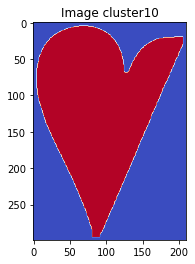

Cluster 11
name: cluster11
centroid: 25.05, 23.25
perimeter: 146
area: 1122
circularity1: 19.00
urr: 111.84, urc: -10.68, ucc: 77.68
bounding box:
left: 5 top :5 right: 38 bottom: 45


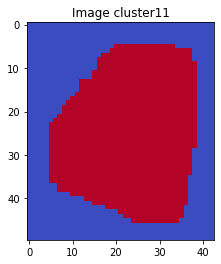

Cluster 12
name: cluster12
centroid: 56.28, 53.81
perimeter: 486
area: 8348
circularity1: 28.29
urr: 839.38, urc: -21.63, ucc: 651.56
bounding box:
left: 5 top :5 right: 108 bottom: 129


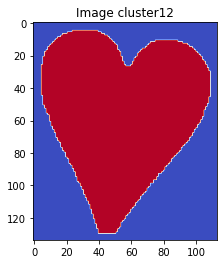

Cluster 13
name: cluster13
centroid: 158.14, 153.42
perimeter: 1716
area: 49884
circularity1: 59.03
urr: 5182.72, urc: -364.38, ucc: 4580.99
bounding box:
left: 5 top :5 right: 280 bottom: 318


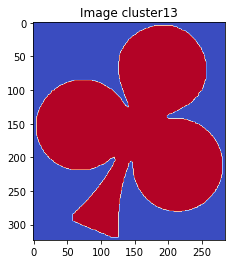

Cluster 14
name: cluster14
centroid: 79.32, 56.27
perimeter: 584
area: 8393
circularity1: 40.64
urr: 947.83, urc: 22.29, ucc: 604.75
bounding box:
left: 5 top :5 right: 110 bottom: 148


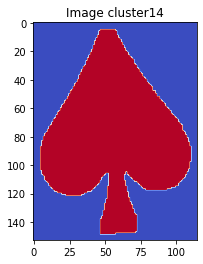

Cluster 15
name: cluster15
centroid: 70.16, 68.40
perimeter: 654
area: 9275
circularity1: 46.11
urr: 937.71, urc: -58.75, ucc: 830.39
bounding box:
left: 5 top :5 right: 122 bottom: 136


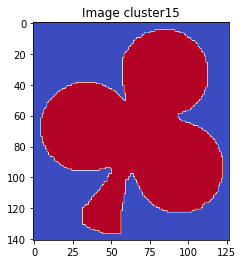

Cluster 16
name: cluster16
centroid: 103.74, 63.41
perimeter: 806
area: 11339
circularity1: 57.29
urr: 2189.80, urc: 814.20, ucc: 1063.55
bounding box:
left: 5 top :5 right: 149 bottom: 198


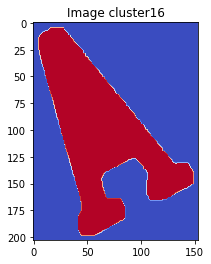

Cluster 17
name: cluster17
centroid: 59.04, 50.22
perimeter: 398
area: 5974
circularity1: 26.52
urr: 593.85, urc: 77.27, ucc: 433.08
bounding box:
left: 5 top :5 right: 96 bottom: 113


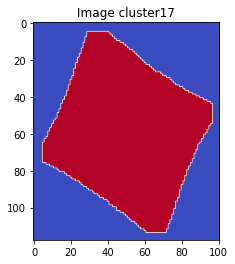

Cluster 18
name: cluster18
centroid: 106.69, 80.74
perimeter: 1134
area: 13914
circularity1: 92.42
urr: 3469.82, urc: -735.93, ucc: 1295.79
bounding box:
left: 5 top :5 right: 159 bottom: 208


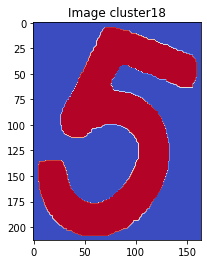

Cluster 19
name: cluster19
centroid: 161.51, 158.58
perimeter: 1728
area: 54038
circularity1: 55.26
urr: 5391.72, urc: -433.60, ucc: 4948.90
bounding box:
left: 5 top :5 right: 289 bottom: 323


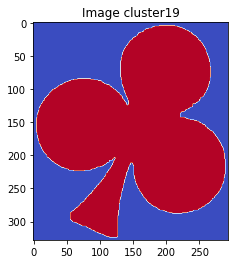

Cluster 20
name: cluster20
centroid: 72.69, 49.53
perimeter: 566
area: 8539
circularity1: 37.52
urr: 877.68, urc: 140.02, ucc: 694.31
bounding box:
left: 5 top :5 right: 107 bottom: 137


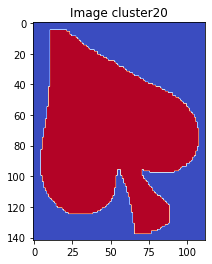

Cluster 21
name: cluster21
centroid: 74.95, 72.28
perimeter: 642
area: 11375
circularity1: 36.23
urr: 1071.15, urc: -88.25, ucc: 983.15
bounding box:
left: 5 top :5 right: 130 bottom: 145


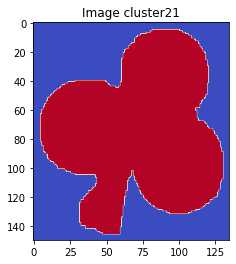

Cluster 22
name: cluster22
centroid: 162.91, 132.43
perimeter: 1706
area: 49810
circularity1: 58.43
urr: 5054.65, urc: -342.93, ucc: 4605.00
bounding box:
left: 5 top :5 right: 281 bottom: 314


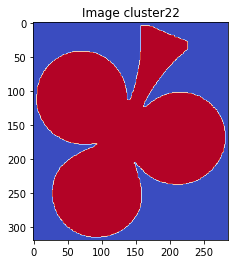

In [44]:
image = Objects_Extraction('./Image/image2.pgm')

Cluster 4
name: cluster4
centroid: 101.05, 68.59
perimeter: 662
area: 10477
circularity1: 41.83
urr: 2079.14, urc: -211.35, ucc: 580.60
bounding box:
left: 5 top :5 right: 109 bottom: 193


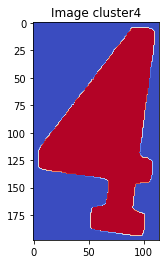

Cluster 6
name: cluster6
centroid: 94.39, 62.61
perimeter: 1018
area: 9909
circularity1: 104.58
urr: 3693.35, urc: 282.07, ucc: 857.84
bounding box:
left: 5 top :5 right: 116 bottom: 195


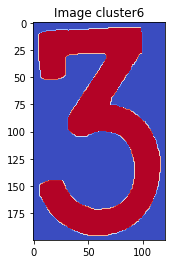

Cluster 7
name: cluster7
centroid: 103.38, 75.61
perimeter: 1082
area: 10639
circularity1: 110.04
urr: 3261.64, urc: -603.81, ucc: 1113.59
bounding box:
left: 5 top :5 right: 148 bottom: 200


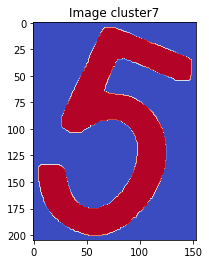

Cluster 9
name: cluster9
centroid: 103.47, 72.23
perimeter: 1028
area: 9420
circularity1: 112.19
urr: 3717.57, urc: 683.25, ucc: 1045.42
bounding box:
left: 5 top :5 right: 141 bottom: 200


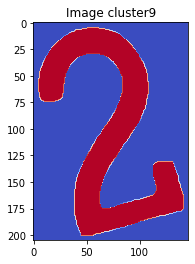

Cluster 10
name: cluster10
centroid: 117.61, 91.76
perimeter: 1076
area: 31481
circularity1: 36.78
urr: 4383.62, urc: -174.51, ucc: 1988.88
bounding box:
left: 5 top :5 right: 205 bottom: 294


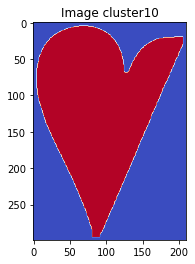

Cluster 12
name: cluster12
centroid: 56.28, 53.81
perimeter: 486
area: 8348
circularity1: 28.29
urr: 839.38, urc: -21.63, ucc: 651.56
bounding box:
left: 5 top :5 right: 108 bottom: 129


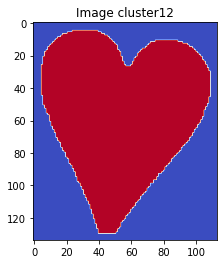

Cluster 13
name: cluster13
centroid: 158.14, 153.42
perimeter: 1716
area: 49884
circularity1: 59.03
urr: 5182.72, urc: -364.38, ucc: 4580.99
bounding box:
left: 5 top :5 right: 280 bottom: 318


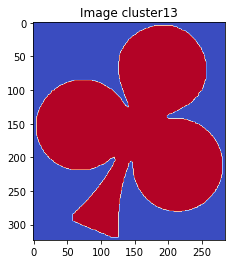

Cluster 14
name: cluster14
centroid: 79.32, 56.27
perimeter: 584
area: 8393
circularity1: 40.64
urr: 947.83, urc: 22.29, ucc: 604.75
bounding box:
left: 5 top :5 right: 110 bottom: 148


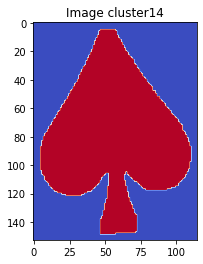

Cluster 15
name: cluster15
centroid: 70.16, 68.40
perimeter: 654
area: 9275
circularity1: 46.11
urr: 937.71, urc: -58.75, ucc: 830.39
bounding box:
left: 5 top :5 right: 122 bottom: 136


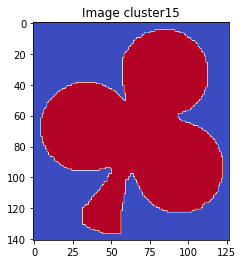

Cluster 16
name: cluster16
centroid: 103.74, 63.41
perimeter: 806
area: 11339
circularity1: 57.29
urr: 2189.80, urc: 814.20, ucc: 1063.55
bounding box:
left: 5 top :5 right: 149 bottom: 198


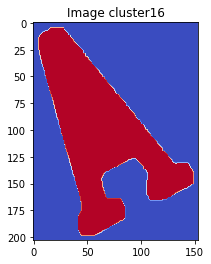

Cluster 17
name: cluster17
centroid: 59.04, 50.22
perimeter: 398
area: 5974
circularity1: 26.52
urr: 593.85, urc: 77.27, ucc: 433.08
bounding box:
left: 5 top :5 right: 96 bottom: 113


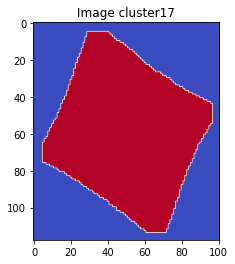

Cluster 18
name: cluster18
centroid: 106.69, 80.74
perimeter: 1134
area: 13914
circularity1: 92.42
urr: 3469.82, urc: -735.93, ucc: 1295.79
bounding box:
left: 5 top :5 right: 159 bottom: 208


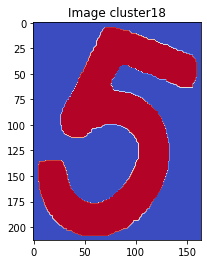

Cluster 19
name: cluster19
centroid: 161.51, 158.58
perimeter: 1728
area: 54038
circularity1: 55.26
urr: 5391.72, urc: -433.60, ucc: 4948.90
bounding box:
left: 5 top :5 right: 289 bottom: 323


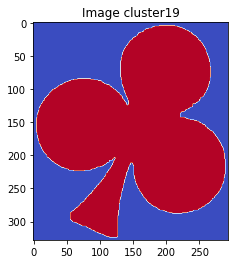

Cluster 20
name: cluster20
centroid: 72.69, 49.53
perimeter: 566
area: 8539
circularity1: 37.52
urr: 877.68, urc: 140.02, ucc: 694.31
bounding box:
left: 5 top :5 right: 107 bottom: 137


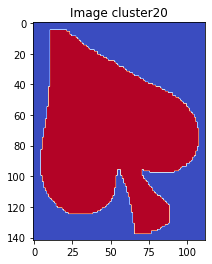

Cluster 21
name: cluster21
centroid: 74.95, 72.28
perimeter: 642
area: 11375
circularity1: 36.23
urr: 1071.15, urc: -88.25, ucc: 983.15
bounding box:
left: 5 top :5 right: 130 bottom: 145


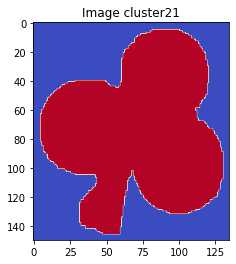

Cluster 22
name: cluster22
centroid: 162.91, 132.43
perimeter: 1706
area: 49810
circularity1: 58.43
urr: 5054.65, urc: -342.93, ucc: 4605.00
bounding box:
left: 5 top :5 right: 281 bottom: 314


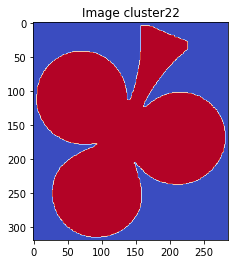

In [45]:
# delete the noise clusters
image.delete_cluster(1,2,3,5,8,11)
image.display_all()